In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
import warnings
warnings.filterwarnings("ignore")

# Satellite configuration dictionary
SATELLITE_CONFIGS = {
    'cs2': {
        'name': 'CryoSat-2',
        'file_path': 'cs2/CryoSat-2_marked.csv',
        'features': ['Brouwer mean motion'],
        'output_dir': 'cs2_ARIMA',
        'plot_start_date': '2013-01-01',
        'plot_end_date': '2013-12-31'
    },
    'fy2f': {
        'name': 'Fengyun-2F',
        'file_path': 'fy2f/Fengyun-2F_marked.csv',
        'features': ['Brouwer mean motion', 'eccentricity'],
        'output_dir': 'fy2f_ARIMA',
        'plot_start_date': '2014-01-01',
        'plot_end_date': '2014-12-31'
    },
    's3a': {
        'name': 'Sentinel-3A',
        'file_path': 's3a/Sentinel-3A_marked.csv',
        'features': ['Brouwer mean motion'],
        'output_dir': 's3a_ARIMA',
        'plot_start_date': '2017-01-01',
        'plot_end_date': '2017-12-31'
    }
}

# Select the satellite to analyze
SATELLITE = 'fy2f'

config = SATELLITE_CONFIGS[SATELLITE]
FILE_PATH = config['file_path']
FEATURES = config['features']
OUTPUT_DIR = config['output_dir']
PLOT_START_DATE = config['plot_start_date']
PLOT_END_DATE = config['plot_end_date']

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [10]:
def plot_time_series_and_diffs(data, feature_name):
    """绘制原始时间序列和各阶差分图"""
    fig, axes = plt.subplots(2, 1, figsize=(6, 4))
    
    # 原始时间序列
    axes[0].plot(data)
    axes[0].set_title(f'{feature_name} - Original Time Series')
    axes[0].grid(True)
    
    # 绘制1-2阶差分
    for i in range(1, 2):
        diff_data = pd.Series(data).diff(i).dropna()
        axes[i].plot(diff_data)
        axes[i].set_title(f'{feature_name} - {i}th Order Differencing')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{feature_name}_differencing.png'))
    plt.show()

def plot_acf_pacf(data, feature_name, lags=40):
    """绘制ACF和PACF图"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))
    
    plot_acf(data, lags=lags, ax=ax1, title=f'{feature_name} - ACF')
    
    plot_pacf(data, lags=lags, ax=ax2, title=f'{feature_name} - PACF')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{feature_name}_acf_pacf.png'))
    plt.show()

def adf_test(data, feature_name):
    """ADF检验"""
    result = adfuller(data)
    print(f'\nADF result - {feature_name}:')
    print(f'ADF statistic: {result[0]:.4f}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    return result[1] < 0.05  # 返回是否平稳


In [14]:
data = pd.read_csv(FILE_PATH)
data['time'] = pd.to_datetime(data['time'])

# Select the feature to analyze
# You can change the index to select a different feature
feature_idx = 1  
feature = FEATURES[feature_idx]
print(f"\nAnalyzing feature ({feature_idx + 1}/{len(FEATURES)}): {feature}")

# Prepare training data (use all data)
train_data = data[feature].values
train_dates = data['time']

# Prepare plot data (use specified time range)
plot_mask = (data['time'] >= PLOT_START_DATE) & (data['time'] <= PLOT_END_DATE)
plot_data = data[feature].values[plot_mask]
plot_dates = data['time'][plot_mask]


Analyzing feature (2/2): eccentricity



ADF result - eccentricity (0th Order Differencing):
ADF statistic: -4.0321
Critical values:
	1%: -3.4323
	5%: -2.8624
	10%: -2.5672

Recommended differencing order d = 0


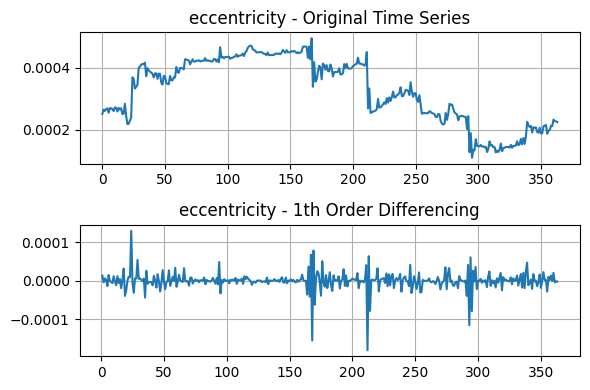

In [15]:
# 2. Determine differencing order d
d = 0
while d < 10:
    if d == 0:
        test_data = train_data
    else:
        test_data = pd.Series(train_data).diff(d).dropna()
    
    is_stationary = adf_test(test_data, f'{feature} ({d}th Order Differencing)')
    if is_stationary:
        print(f'\nRecommended differencing order d = {d}')
        break
    d += 1

plot_time_series_and_diffs(plot_data, feature)

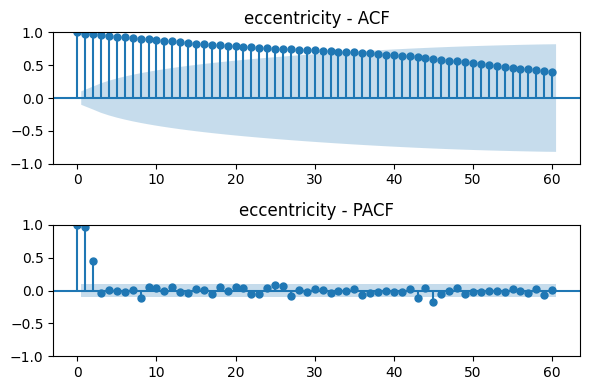

In [16]:
# 3. Plot ACF and PACF for the selected differencing order
d = 0
if d > 0:
    stationary_data = pd.Series(plot_data).diff(d).dropna()
else:
    stationary_data = plot_data

max_lag = 60 
plot_acf_pacf(stationary_data, feature, lags=max_lag)


In [ ]:
# Ranges of p and q to use
suggested_d = [0, 0]
suggested_q = [0, 0]
suggested_p = [1, 2]

In [ ]:
# 5. Save parameter ranges to file
param_suggestions = {
    'd_range': suggested_d,
    'p_range': suggested_p,
    'q_range': suggested_q
}

import json
with open(os.path.join(OUTPUT_DIR, f'{feature}_arima_params.json'), 'w') as f:
    json.dump(param_suggestions, f, indent=4)